In [1]:
# import standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
import pandas as pd

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import datetime
import pickle
from nltk.corpus import stopwords
import re
import regex
import string
from urllib.parse import urlparse

In [2]:
# import ML libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [4]:
from ipynb.fs.defs.FFtraining import FFNetworkBertEmbedding

ImportError: Could not import \\wsl$\Ubuntu\home\zaidek\Part-II-Disertation\Neural Networks\FFtraining.ipynb for ipynb.fs.defs.FFtraining: not a valid ipynb file

In [3]:
with open("losses_bert", "rb") as fb:
    losses_bert = pickle.load(fb)

In [6]:
losses_bert_unpop = [loss for loss in losses_bert if loss <= 1]
losses_bert_pop = [loss for loss in losses_bert if loss > 1]

In [22]:
losses_desc = []
min_loss = 1
for loss in losses_bert_unpop:
    if loss < min_loss:
        losses_desc.append(loss)
        min_loss = loss

In [25]:
def plot_losses(losses):
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(len(losses)), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss")
    plt.show()

def plot_losses_log(losses):
    plt.figure(figsize=(20, 10))
    plt.plot(np.log(np.arange(len(losses))), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss")
    plt.show()

C:\Users\Ethan\AppData\Local\Temp\ipykernel_24376\2500781987.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(len(losses))), losses)


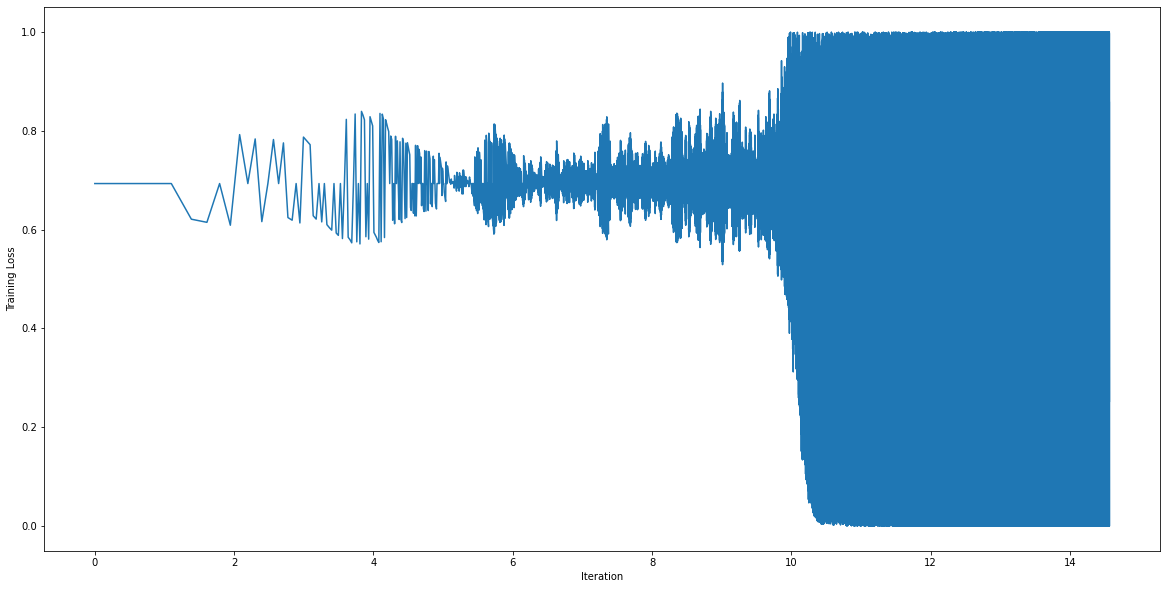

In [26]:
plot_losses_log(losses_bert_unpop)

C:\Users\Ethan\AppData\Local\Temp\ipykernel_24376\2500781987.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(len(losses))), losses)


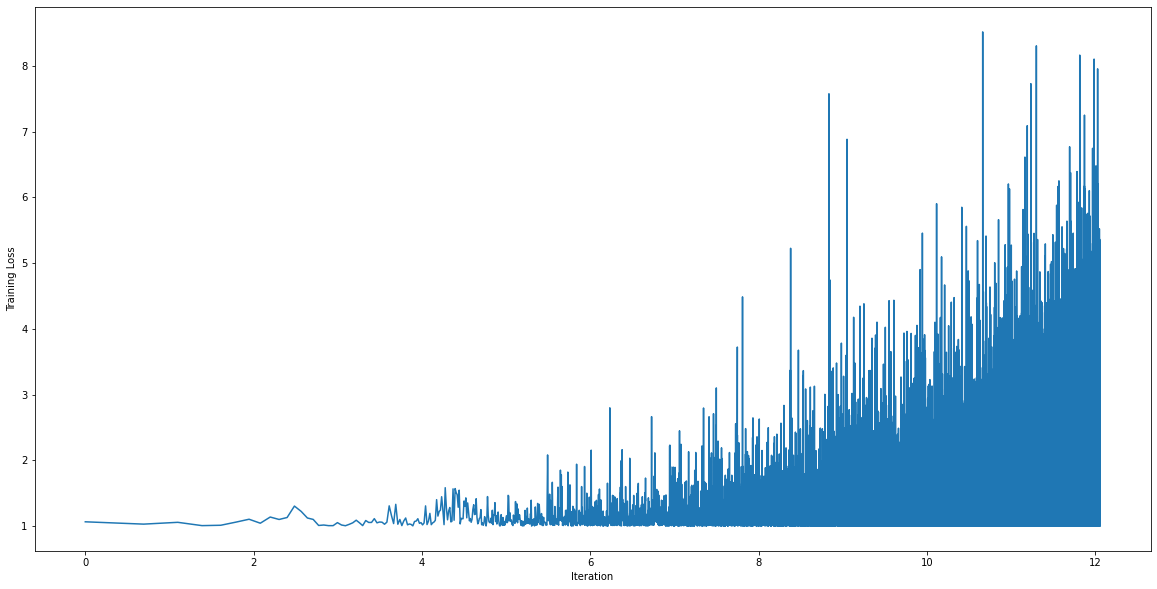

In [27]:
plot_losses_log(losses_bert_pop)

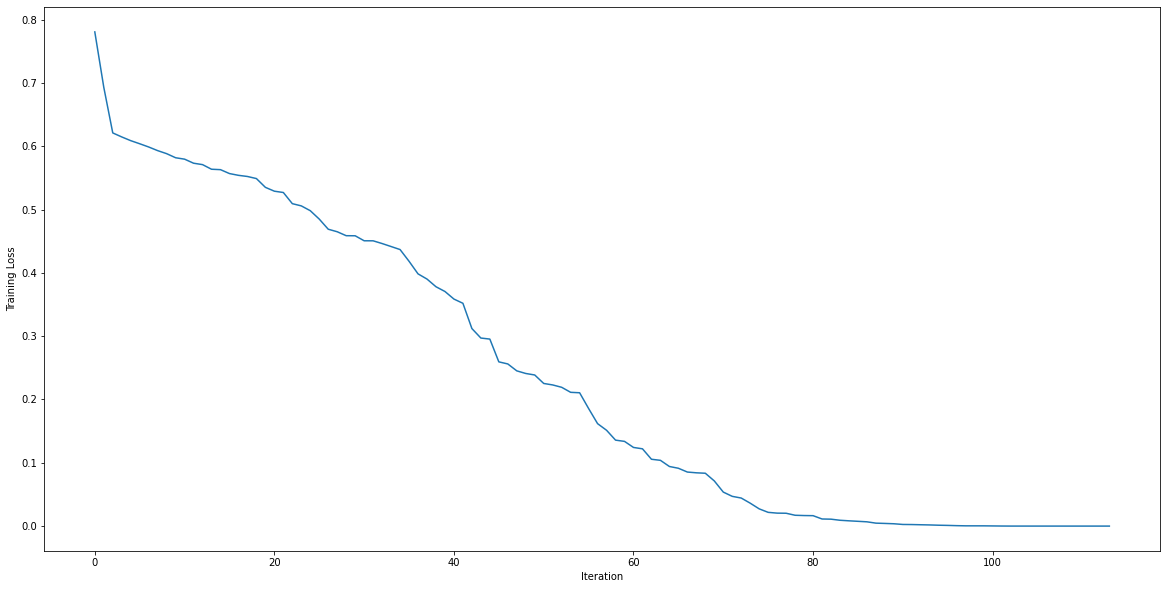

In [28]:
plot_losses(losses_desc)

In [5]:
with open("model_bert", "rb") as fb:
    model_bert = pickle.load(fb)

AttributeError: Can't get attribute 'FFNetworkBertEmbedding' on <module '__main__'>